
# IFCD104 – Tema 2: RNN (LSTM) paso a paso en Python

Este cuaderno implementa una **Red Neuronal Recurrente (LSTM)** para **clasificar series temporales sintéticas** en dos clases:
- **Clase 0**: señal seno de **baja frecuencia** + ruido.  
- **Clase 1**: señal seno de **alta frecuencia** + ruido.  

El objetivo es didáctico: mostrar cómo una LSTM **aprende dependencias temporales**.
Incluye **generación de datos**, **entrenamiento**, **evaluación**, **matriz de confusión**, **ROC-AUC** y **predicciones de ejemplo**.



## 1) Importaciones


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



## 2) Generación del dataset sintético (series temporales)
- Longitud fija de secuencia: **T = 100** pasos.
- Amplitud 1, ruido gaussiano leve.
- Frecuencias: `f_low=1`, `f_high=5` ciclos por secuencia.


In [6]:

rng = np.random.default_rng(42)

T = 100
n_samples_per_class = 2000

def make_signals(n, freq, T=100, noise_std=0.2):
    X = []
    for _ in range(n):
        phase = rng.uniform(0, 2*np.pi)
        t = np.linspace(0, 1, T)
        signal = np.sin(2*np.pi*freq*t + phase)
        signal += rng.normal(0, noise_std, size=T)
        X.append(signal.astype(np.float32))
    return np.array(X, dtype=np.float32)

X0 = make_signals(n_samples_per_class, freq=1, T=T)  # baja frecuencia
X1 = make_signals(n_samples_per_class, freq=5, T=T)  # alta frecuencia

y0 = np.zeros(len(X0), dtype=np.int32)
y1 = np.ones(len(X1), dtype=np.int32)

X = np.concatenate([X0, X1], axis=0)
y = np.concatenate([y0, y1], axis=0)

# Mezclar
idx = rng.permutation(len(X))
X, y = X[idx], y[idx]

# RNN/LSTM espera forma (N, T, features). Aquí features=1
X = X[..., np.newaxis]

# Split train/val/test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.2, random_state=42, stratify=y_train_temp)

X.shape, X_train.shape, X_val.shape, X_test.shape


((4000, 100, 1), (2560, 100, 1), (640, 100, 1), (800, 100, 1))


## 3) Visualización de ejemplos


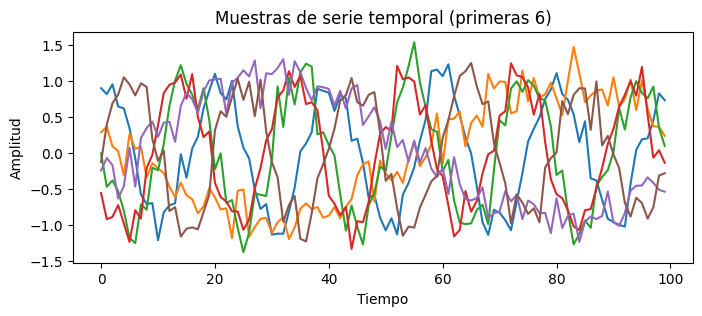

In [7]:

plt.figure(figsize=(8,3))
for i, (xx, yy) in enumerate(zip(X[:6], y[:6])):
    plt.plot(xx.squeeze(), label=f"y={yy}")
plt.title("Muestras de serie temporal (primeras 6)")
plt.xlabel("Tiempo")
plt.ylabel("Amplitud")
plt.show()



## 4) Definición del modelo LSTM
Arquitectura sencilla:
- `LSTM(32)` → `Dropout(0.2)` → `Dense(1, activation='sigmoid')`


In [8]:

inputs = keras.Input(shape=(T, 1))
x = layers.LSTM(32, return_sequences=False)(inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs, name="lstm_freq_classifier")
model.summary()


Model: "lstm_freq_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)


## 5) Compilación y entrenamiento


In [9]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=8,
    batch_size=64,
    verbose=1
)


Epoch 1/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6180 - loss: 0.6488 - val_accuracy: 0.8359 - val_loss: 0.5154
Epoch 2/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9504 - loss: 0.2679 - val_accuracy: 0.9719 - val_loss: 0.1416
Epoch 3/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9988 - loss: 0.0555 - val_accuracy: 1.0000 - val_loss: 0.0320
Epoch 4/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9996 - loss: 0.0277 - val_accuracy: 1.0000 - val_loss: 0.0174
Epoch 5/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9992 - loss: 0.0191 - val_accuracy: 0.9984 - val_loss: 0.0184
Epoch 6/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9977 - loss: 0.0218 - val_accuracy: 0.9906 - val_loss: 0.0528
Epoch 7/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9895 - loss: 0.0558 - val_accuracy: 0.9734 - val_loss: 0.1219
Epoch 8/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9871 - loss: 0.0639 - val_accuracy: 0.9969 - val_loss:


## 6) Curvas de entrenamiento


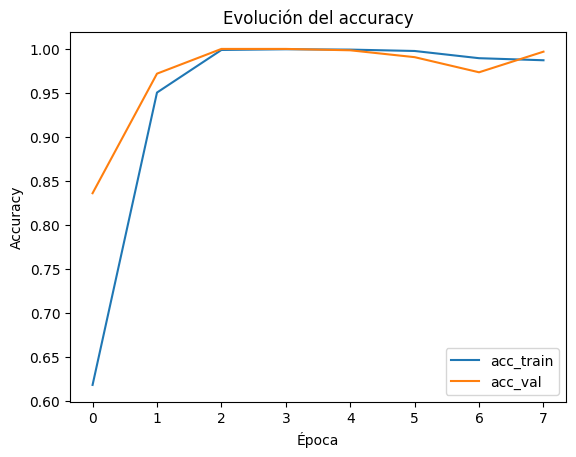

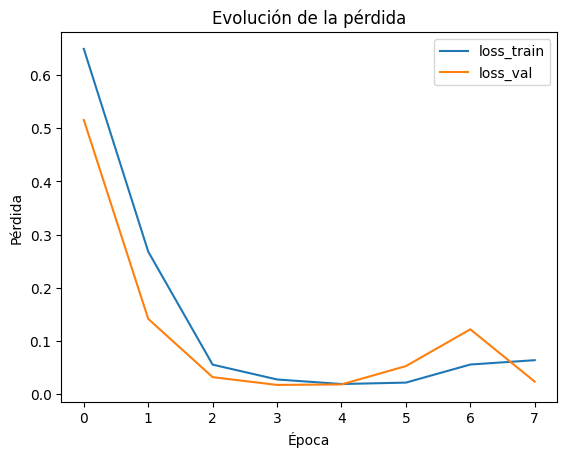

In [10]:

plt.figure()
plt.plot(history.history['accuracy'], label='acc_train')
plt.plot(history.history['val_accuracy'], label='acc_val')
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Evolución del accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='loss_train')
plt.plot(history.history['val_loss'], label='loss_val')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Evolución de la pérdida")
plt.legend()
plt.show()



## 7) Evaluación en test (métricas principales)


Accuracy en test: 0.9975  |  Pérdida en test: 0.0212

Informe de clasificación (test):
              precision    recall  f1-score   support

   baja_frec       1.00      1.00      1.00       400
   alta_frec       1.00      0.99      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



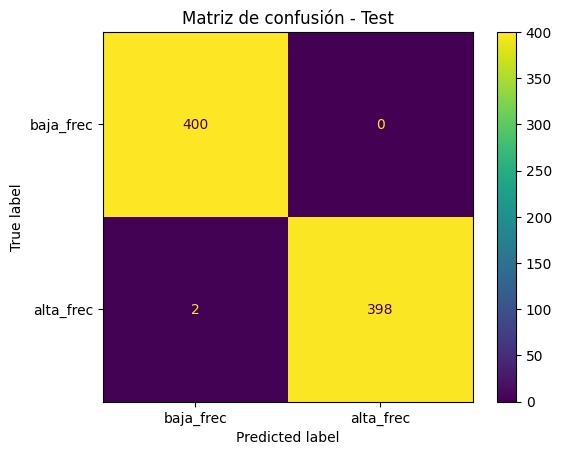

In [11]:

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy en test: {test_acc:.4f}  |  Pérdida en test: {test_loss:.4f}")

# Predicciones para métricas
y_proba = model.predict(X_test, verbose=0).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("\nInforme de clasificación (test):")
print(classification_report(y_test, y_pred, target_names=["baja_frec","alta_frec"]))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["baja_frec","alta_frec"]).plot(values_format='d')
plt.title("Matriz de confusión - Test")
plt.show()



## 8) Curva ROC y AUC


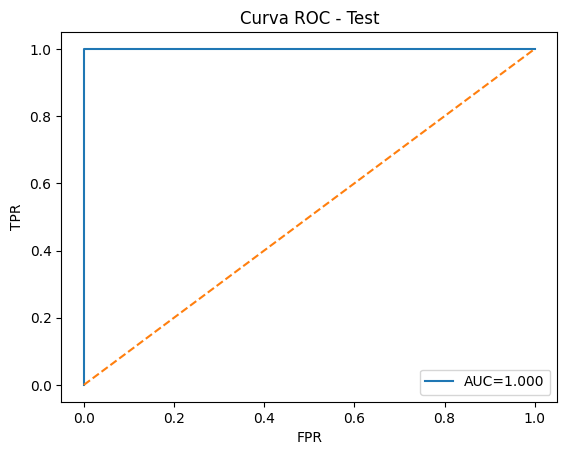

In [12]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - Test")
plt.legend()
plt.show()



## 9) Predicciones de ejemplo


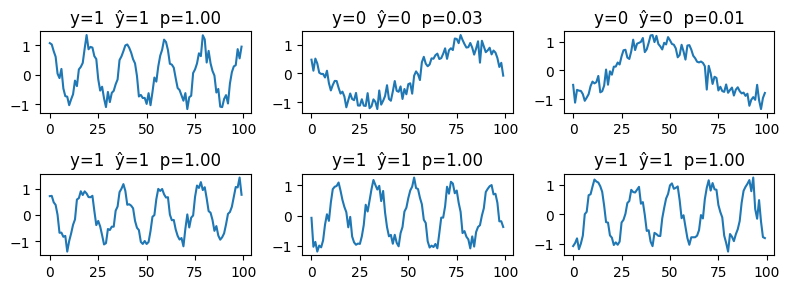

In [13]:

idx = np.random.choice(len(X_test), size=6, replace=False)
plt.figure(figsize=(8,3))
for i, j in enumerate(idx, start=1):
    plt.subplot(2,3,i)
    plt.plot(X_test[j].squeeze())
    plt.title(f"y={y_test[j]}  ŷ={(y_proba[j]>=0.5).astype(int)}  p={y_proba[j]:.2f}")
    plt.tight_layout()
plt.show()



## 10) Guardar y cargar el modelo


In [14]:

model_path = "lstm_freq_classifier.keras"  # Ruta local/relativa segura
model.save(model_path)
print("Modelo guardado en:", model_path)

loaded = keras.models.load_model(model_path)
loss2, acc2 = loaded.evaluate(X_test, y_test, verbose=0)
print(f"Cargado -> Accuracy en test: {acc2:.4f}")


Modelo guardado en: lstm_freq_classifier.keras
Cargado -> Accuracy en test: 0.9975
